## Data Exploration
<b>Objective:</b> Explore astronomical lightcurves from the Photometric LSST Astronomical Time-Series Classification Challenge (PLAsTiCC), reading data from [Kaggle](https://www.kaggle.com/c/PLAsTiCC-2018/data) `.csv` files.

In [1]:
# Imports

# Standard
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Auxilliary
import george
from george import kernels

from scipy.optimize import minimize

In [2]:
print(george.__file__)

/epyc/opt/anaconda/lib/python3.7/site-packages/george/__init__.py


In [3]:
# Settings
rcParams['figure.figsize'] = [6.5, 6.5]
rcParams['font.size'] = 10

In [10]:
# PLAsTiCC Data
# object_id, mjd, passband, flux, flux_err, detected
train = pd.read_csv("../../../../plasticc/training_set.csv")

# object_id, ra, decl, gal_l, gal_b, ddf, hostgal_specz, hostgal_photoz, hostgal_photoz_err, distmod, mwebv, target
train_meta = pd.read_csv("../../../../plasticc/training_set_metadata.csv")

### How many known classes are in the training set?

In [11]:
classes = train_meta['target'].unique()
classes.sort()

print("There are {} known classes in the PLAsTiCC training set. \nClasses are labeled as {}"\
      .format(len(classes), classes))

There are 14 known classes in the PLAsTiCC training set. 
Classes are labeled as [ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


### How many objects are in each class?

In [12]:
class_sizes = [len(train_meta['object_id'][train_meta['target'] == cl]) for cl in classes]

size_sort = np.argsort(class_sizes)
classes_str_sort = np.zeros(len(size_sort), dtype=int) 
class_sizes_sort = np.zeros(len(size_sort), dtype=int) 

# Populate list of class labels (strings) and sizes for all classes
for i in range(0, len(size_sort)): 
    classes_str = [str(i) for i in classes] 
    classes_str_sort[i] = classes_str[size_sort[i]] 
    class_sizes_sort[i] = class_sizes[size_sort[i]]

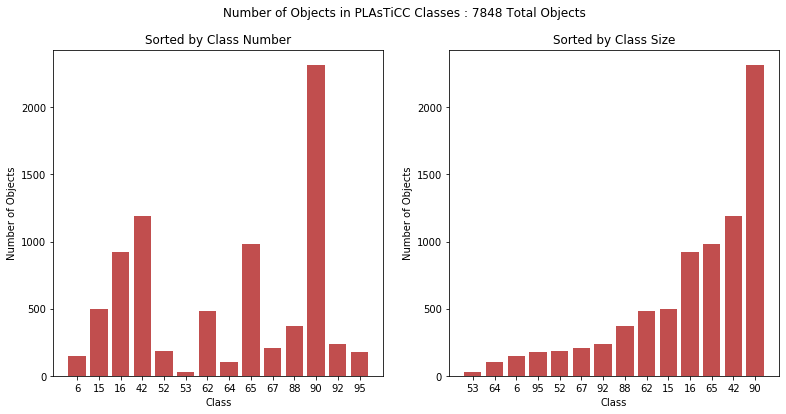

In [13]:
# Plot
n_classes = np.arange(len(classes))

plt.figure(figsize=(13, 6))
plt.subplot(1,2,1)
plt.bar(n_classes, class_sizes, align='center', alpha=0.8, color = 'firebrick')
plt.xticks(n_classes, classes_str)
plt.xlabel('Class')
plt.ylabel('Number of Objects')
plt.title('Sorted by Class Number')

plt.subplot(1,2,2)
plt.bar(n_classes, class_sizes_sort, align='center', alpha=0.8, color = 'firebrick')
plt.xticks(n_classes, classes_str_sort)
plt.xlabel('Class')
plt.ylabel('Number of Objects')
plt.title('Sorted by Class Size')
# plt.title('Number of Objects in PLAsTiCC Classes')

plt.suptitle("Number of Objects in PLAsTiCC Classes : {} Total Objects".format(sum(class_sizes)))
plt.show()

### What are the redshifts of objects in each class?

All redshifts for Class 6 set to 0.0
All redshifts for Class 16 set to 0.0
All redshifts for Class 53 set to 0.0
All redshifts for Class 65 set to 0.0
All redshifts for Class 92 set to 0.0


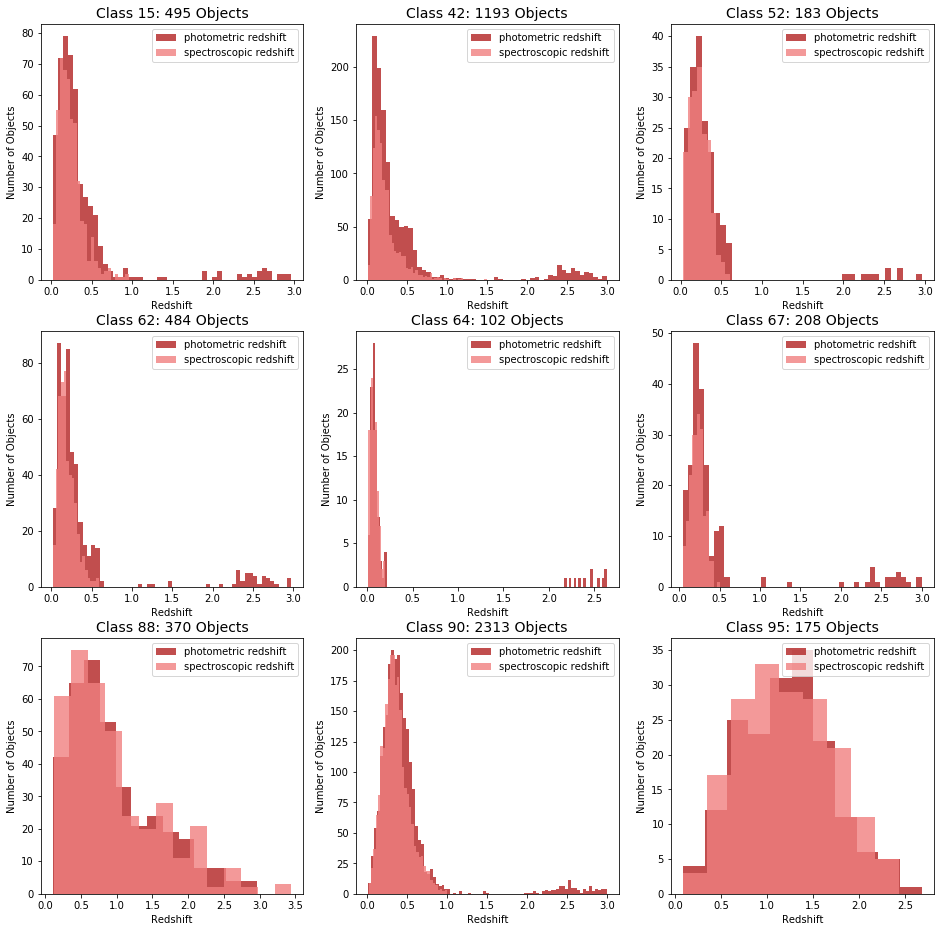

In [14]:
speczs = [train_meta['hostgal_specz'][train_meta['target'] == cl] for cl in classes]
photozs = [train_meta['hostgal_photoz'][train_meta['target'] == cl] for cl in classes]

plt.figure(figsize=(16,16))
j = 1

for i, individual_class in enumerate(classes):
    if max(photozs[i]) == 0.0:
        print(f'All redshifts for Class {individual_class} set to 0.0')
    else: 
        plt.subplot(3,3,j)
        plt.hist(photozs[i], bins = 'fd', color='firebrick', label='photometric redshift', alpha = 0.8)
        plt.hist(speczs[i], bins = 'fd', color='lightcoral', label='spectroscopic redshift', alpha = 0.8)
        plt.xlabel('Redshift')
        plt.ylabel('Number of Objects')
        plt.title(f'Class {individual_class}: {class_sizes[i]} Objects',size=14)
        plt.legend(loc='upper right', ncol=1)
        j += 1
plt.show()

Most objects within the PLAsTiCC training set are only observed at low redshifts. In order to represent the full range of observations within the testing set, we will need to augment the training set.

### What do the lightcurves really look like?

In [15]:
# Let's look at the data by individual class
# Create a dictionary of classes and pull all of the training data (every single observation) for each class
data_by_class = {cl : train[train['object_id'].isin(train_meta['object_id'][train_meta['target'] == cl])] \
                for cl in classes}

# ... and look at the objects by class
# Determine the unique objects within an individual class
objects_by_class = {cl : data_by_class[cl]['object_id'].unique() \
                  for cl in classes}

# ... and lightcurves by class
# Sort all the data by object
lightcurves_by_class = { cl : [ data_by_class[cl][data_by_class[cl]['object_id'] == o] for o in objects_by_class[cl] ] \
                       for cl in classes }

In [16]:
# Separate the light curves for each passband
def lightcurves_bypassband(data):
    return [ data[data['passband'] == i] for i in data['passband'].unique() ]

# Plot the light curve of a selected object in each passband
def plot_lightcurves(data, example_object, cl):
    data_bypassband = lightcurves_bypassband(data)
    
    passbands = { 0 : 'u', 1 : 'g', 2 : 'r', 3 : 'i', 4 : 'z', 5 : 'y' }
    colors = ['maroon', 'firebrick', 'crimson', 'tomato', 'lightsalmon', 'k']
    
    for i, data_passband in enumerate(data_bypassband):
        plt.errorbar(data_passband['mjd'], data_passband['flux'], yerr = data_passband['flux_err'], fmt = 'o',\
                     color = colors[i], markersize = 5, label="{}".format(passbands[i]))

    plt.xlabel('Time [MJD]')
    plt.ylabel('Flux')
    plt.title(f'Class {cl} : Object {objects_by_class[cl][example_object]}', size=14)

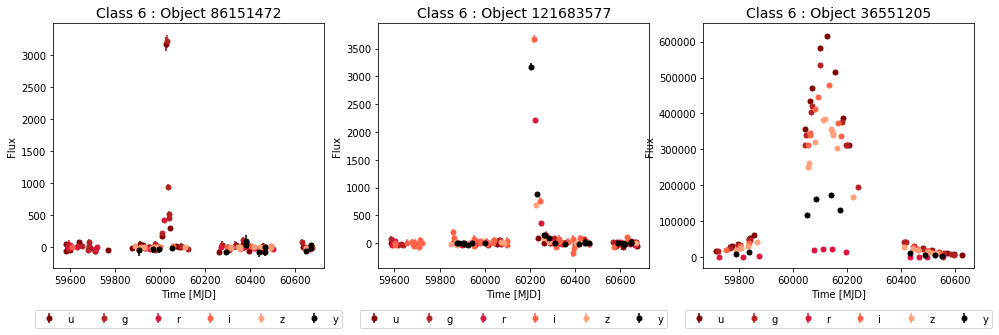

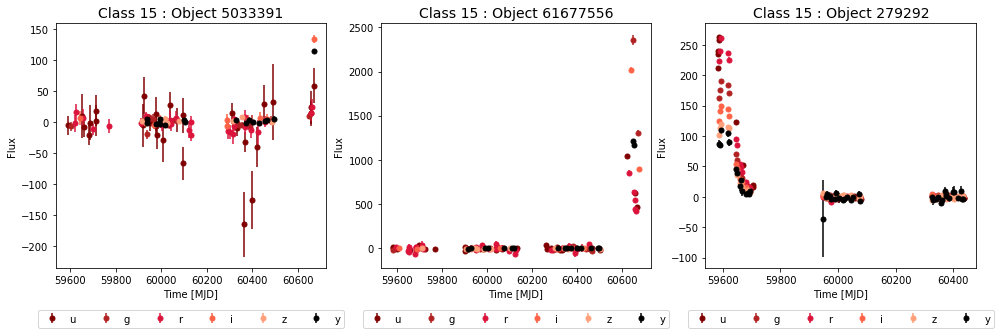

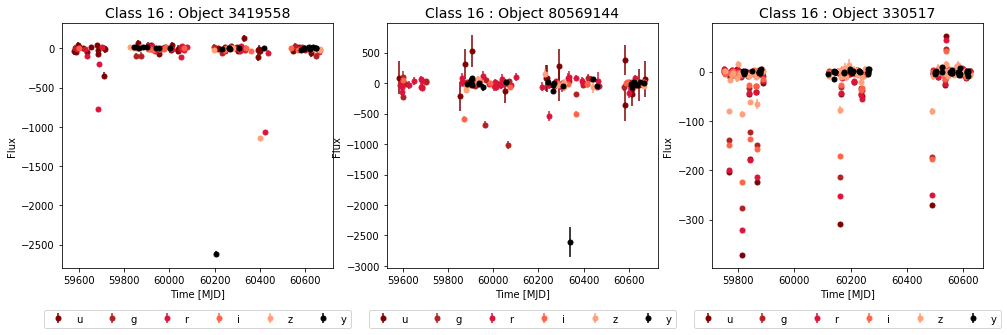

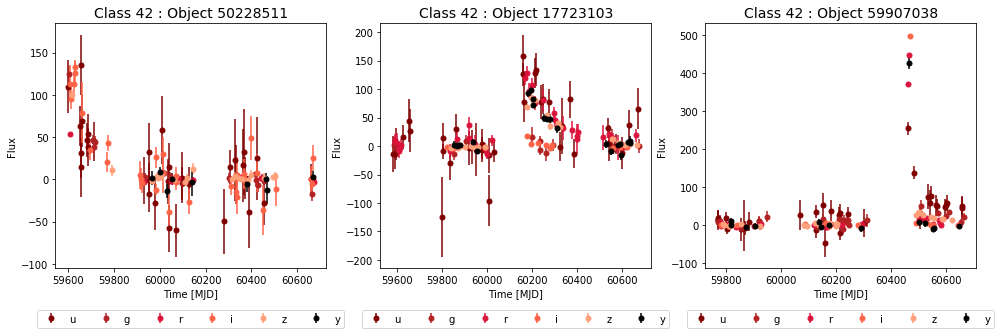

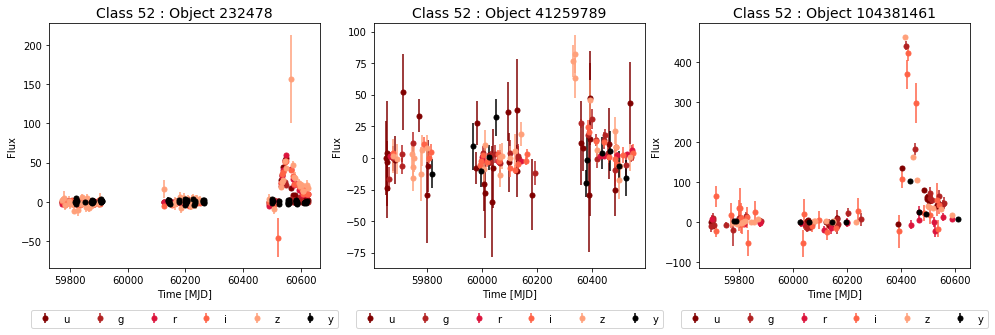

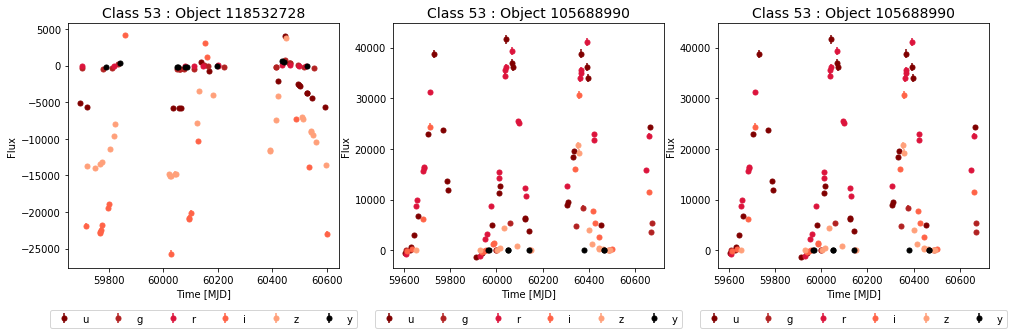

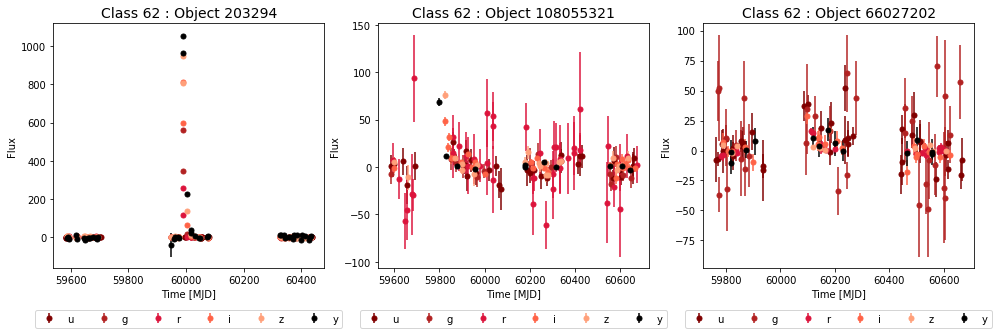

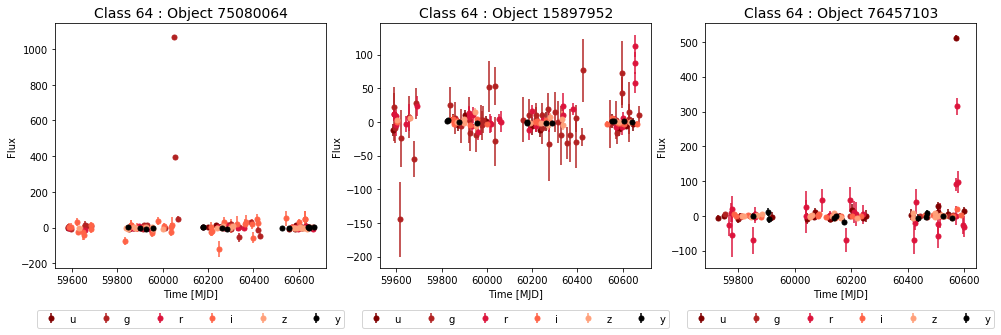

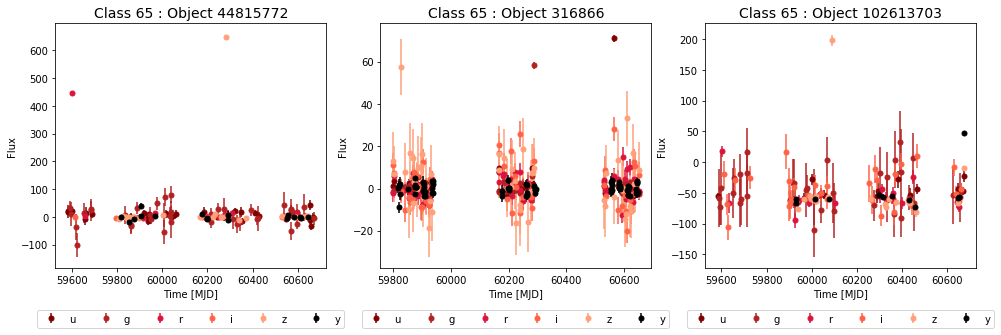

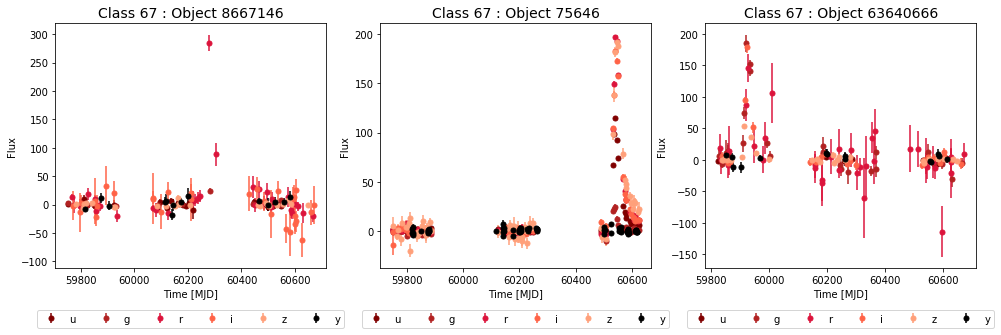

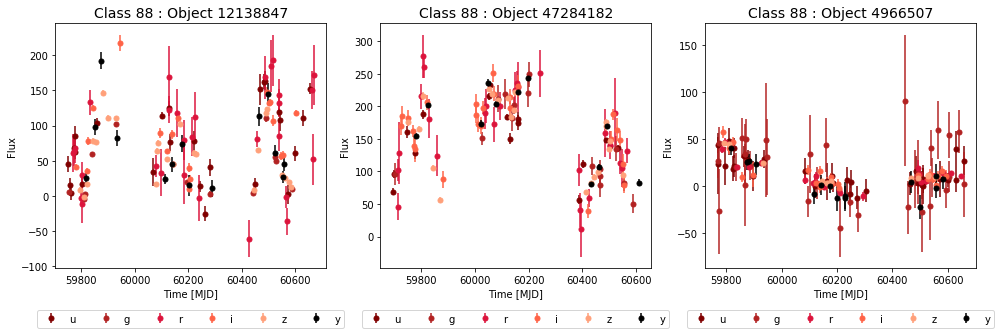

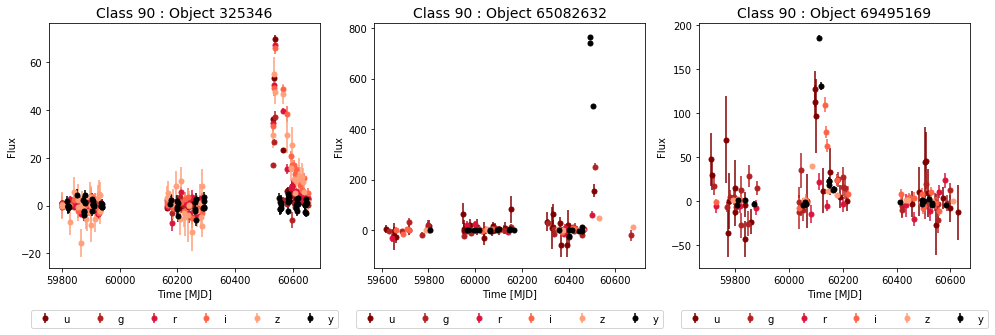

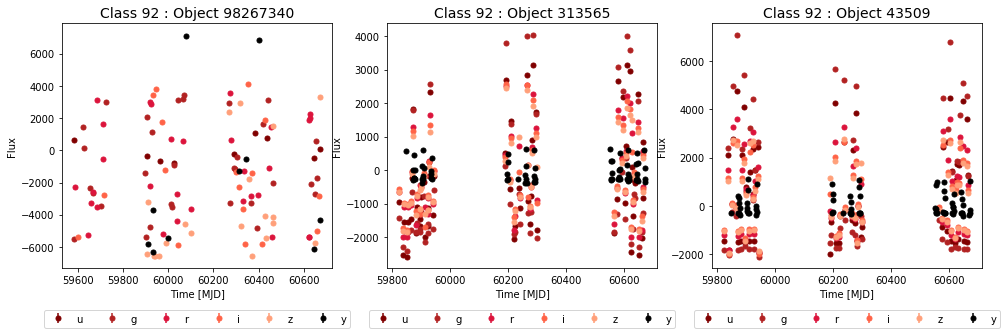

In [ ]:
# Plot a light curve, indicating which class the light curve occupies

for j in range(len(classes)):
    cl = classes[j]
    n_objects = len(lightcurves_by_class[cl])

    plt.figure(figsize=(16.5, 4.5))

    for i in range(3):
        plt.subplot(1, 3, i+1)
    
        example_object = np.random.randint(n_objects)
        plot_lightcurves(lightcurves_by_class[cl][example_object], example_object, cl)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
    
    plt.savefig("data-exploration-images/Example Lightcurve Class "+str(cl)+".png")
    plt.show()

Great. I feel like I have a general overview of what PLAsTiCC lightcurves are about.

## Resting place